# Obtaining Tweets For A Particular Year

As per news reports, Kanye West's account was blocked on 2nd December 2022. As per Wayback Machine, the last available snapshot of the Twitter account was available on Fri, 02 Dec 2022 05:30:51 GMT (http://web.archive.org/web/20221202053051/https://twitter.com/kanyewest). Therefore, for 2022, we will extract all the tweets.

In [7]:
# Package imports

import requests
from bs4 import BeautifulSoup
import lxml
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import NoSuchElementException, StaleElementReferenceException
import pickle
import time
import re
from urllib.error import HTTPError

In [8]:
# Fetch the 2022 year webpage
kanye_tweets_calendar_url = "http://web.archive.org/web/20220101000000*/https://twitter.com/kanyewest"
web_archive_response = requests.get(kanye_tweets_calendar_url)
web_archive_response.raise_for_status()

In [9]:
# Use BeautifulSoup to parse the html later
html = BeautifulSoup(web_archive_response.text, 'lxml')
print(html.prettify())

<!DOCTYPE html>
<html lang="en">
 <head>
  <title>
   Wayback Machine
  </title>
  <script>
   /*
    @licstart  The following is the entire license notice for the JavaScript code in this page.

    Copyright (C) 2020 Internet Archive

    The JavaScript code in this page is free software: you can
    redistribute it and/or modify it under the terms of the GNU Affero
    General Public License as published by the Free Software
    Foundation, either version 3 of the License, or (at your option)
    any later version.  The code is distributed WITHOUT ANY WARRANTY;
    without even the implied warranty of MERCHANTABILITY or FITNESS
    FOR A PARTICULAR PURPOSE.  See the GNU GPL for more details.

    As additional permission under GNU AGPL version 3 section 7, you
    may distribute non-source (e.g., minimized or compacted) forms of
    that code without the copy of the GNU AGPL normally required by
    section 4, provided you include this license notice and a URL
    through which recip

The above HTML generated doesn't contain anything in the `<div>` with the ID <b>react-wayback-search</b>, so we have to use Selenium

In [10]:
# Edge browser setup for Selenium
edge_driver_path = "edgedriver_win64/msedgedriver.exe"
edge_options = webdriver.EdgeOptions()
browser = webdriver.Edge(executable_path=edge_driver_path, options=edge_options)
action = ActionChains(browser)

/tmp/ipykernel_4138/2147376200.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser = webdriver.Edge(executable_path=edge_driver_path, options=edge_options)


In [11]:
# Fetch kanye tweets calendar URL using Selenium
from selenium.common.exceptions import TimeoutException
browser.set_page_load_timeout(10) # ten seconds should be enough

try:
    browser.get(kanye_tweets_calendar_url)
except TimeoutException:
    browser.execute_script("window.stop();")

In [12]:
# Print the obtained html
html = BeautifulSoup(browser.page_source,'lxml')
print(html.prettify())

<html lang="en">
 <head>
  <style>
   body {transition: opacity ease-in 0.2s; } 
body[unresolved] {opacity: 0; display: block; overflow: hidden; position: relative; }
  </style>
  <title>
   Wayback Machine
  </title>
  <script>
   /*
    @licstart  The following is the entire license notice for the JavaScript code in this page.

    Copyright (C) 2020 Internet Archive

    The JavaScript code in this page is free software: you can
    redistribute it and/or modify it under the terms of the GNU Affero
    General Public License as published by the Free Software
    Foundation, either version 3 of the License, or (at your option)
    any later version.  The code is distributed WITHOUT ANY WARRANTY;
    without even the implied warranty of MERCHANTABILITY or FITNESS
    FOR A PARTICULAR PURPOSE.  See the GNU GPL for more details.

    As additional permission under GNU AGPL version 3 section 7, you
    may distribute non-source (e.g., minimized or compacted) forms of
    that code withou

The above HTML generated contains information in the `<div>` with the ID <b>react-wayback-search</b>

Now, we find all divs with the id `calendar-day`: Each div after hovering on it contains the required links

In [13]:
# obtain all calendar days that contain the actual links 
calendar_days = []
# wait for the page to load so that it contains the calendar days
while (len(calendar_days) == 0):
    time.sleep(0.1)
    calendar_days = browser.find_elements("xpath", "//div[contains(@class, 'calendar-day')]")

In [14]:
# obtain all links

def obtain_kanye_tweet_links(calendar_days):
    kanye_tweet_links = []
    
    for c in list(calendar_days):
        while (True):
            try: 
                time.sleep(0.2)
                action.move_to_element(c).perform()
                links = browser.find_elements("xpath", "//a[contains(@class, 'snapshot-link')]")
                # the page fetches the links sometimes, so need to wait
                while (len(links) == 0):
                    time.sleep(0.1)
                    links = browser.find_elements("xpath", "//a[contains(@class, 'snapshot-link')]")
                for link in links:
                    kanye_tweet_links.append(link.get_attribute("href"))
                    print(link.get_attribute("href"))
                break
            # if we encounter an exception, then redo operations again
            except (NoSuchElementException, StaleElementReferenceException) as e:
                print(e)
                pass
            
    return kanye_tweet_links

In [15]:
# store links as the above operation takes a lot of time
# kanye_tweet_links_2022 = obtain_kanye_tweet_links(calendar_days)
# with open('kanye_tweet_links_2022.pickle', 'wb') as file:
#     pickle.dump(kanye_tweet_links_2022, file)

In [16]:
browser.quit()

In [17]:
# retrieve all kanye tweet links for the year 2022
with open('kanye_tweet_links_2022.pickle', 'rb') as file:
    kanye_tweet_links_2022 = pickle.load(file)

In [18]:
# for the year 2022, obtain all the tweets
# since the tweets could repeat across snapshots, we store in a dictionary

def obtain_all_tweets():
    kanye_tweets_2022 = {}
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5)\
                AppleWebKit/537.36 (KHTML, like Gecko) Cafari/537.36'}

    for i in range(len(kanye_tweet_links_2022)):
        while (True):
            try: 
                print(i, len(kanye_tweets_2022), kanye_tweet_links_2022[i])
                time.sleep(0.3)
                response = requests.get(kanye_tweet_links_2022[i], headers=headers)
                html = BeautifulSoup(response.text, 'lxml')

                # type 1 - from normal Twitter archive
                tweets = html.find_all('p', {'class': 'tweet-text'})
                for tweet in tweets:
                    # remove pic.twitter.com/xyz text
                    modified_tweet = re.sub(r"pic\.twitter\.com/\S+", "", tweet.text)
                    kanye_tweets_2022[modified_tweet] = True

                # type 2 - from web archive archive
                tweets = html.find_all('div', {'data-testid': "tweetText"})
                for tweet in tweets:
                    modified_tweet = tweet.text
                    kanye_tweets_2022[modified_tweet] = True

                break
            except Exception: 
                time.sleep(1)
                pass
            
    return kanye_tweets_2022

In [19]:
# store tweets as the above operation takes a lot of time
# kanye_tweets_2022 = obtain_all_tweets()
# with open('kanye_tweet_2022.pickle', 'wb') as file:
#     pickle.dump(kanye_tweets_2022, file)

In [20]:
# retrieve all kanye tweet for the year 2022
with open('kanye_tweet_2022.pickle', 'rb') as file:
    kanye_tweets_2022 = pickle.load(file)

# Tweet Sentiment Analysis

Once tweets are obtained, we perform sentiment analysis on it using NLTK

In [21]:
import nltk.corpus
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/maanas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
# download stopwords to remove from tweets
stopwords = nltk.corpus.stopwords.words("english")

# lemmatization - find root word
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/maanas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [48]:
# obtain all relevant words in tweets
all_words_tweets = {}
for tweet in kanye_tweets_2022:
    tweet_words = tweet.split(' ')
    for tweet_word in tweet_words:
        # lowercasing
        tweet_word = tweet_word.lower()
        # lemmatize
        tweet_word = nltk.WordNetLemmatizer().lemmatize(tweet_word)

        # remove stopwords and empty strings
        if tweet_word in stopwords or tweet_word == "":
            continue
            
        # remove hash of hashtag
        tweet_word = re.sub(r'#(\w+)', r'\1', tweet_word)
        
        if tweet_word not in all_words_tweets:
            all_words_tweets[tweet_word] = 0
        all_words_tweets[tweet_word] += 1

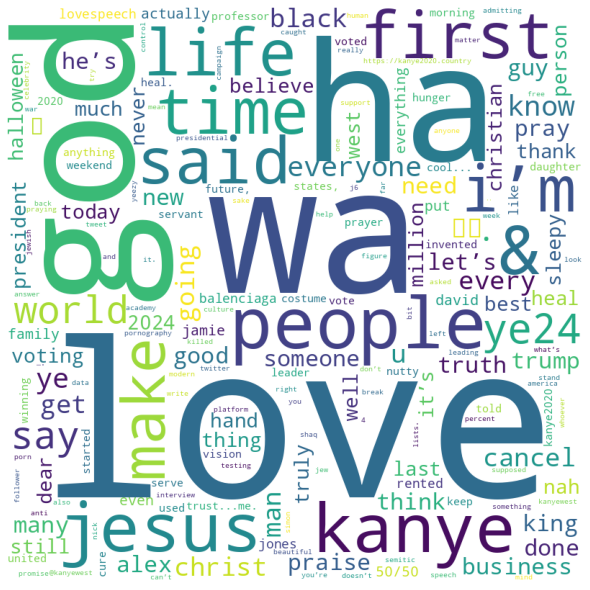

In [49]:
# visualization - wordcloud for tweet words
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# create a WordCloud object with the given parameters
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      min_font_size=10).generate_from_frequencies(all_words_tweets)

# plot the WordCloud image using matplotlib
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

# display the image
plt.show()

From the tweets, we can notice that the most commonly used words, "love", "god", "people", "jesus", "life" suggest that the tweets are mostly "positive" in nature. This is because we also notice curse words like "fuck" that, even though less in number, could suggest that Kanye West has a "negative" social media presence as well. 

In [50]:
# filter the dictionary for items with frequency >= 5
all_words_tweets_filtered = {k: v for k, v in all_words_tweets.items() if v >= 5}

# sort the dictionary by value (frequency) in descending order
all_words_tweets_sorted_freq = dict(sorted(all_words_tweets_filtered.items(), key=lambda item: item[1], reverse=True))

# print the sorted dictionary
print(all_words_tweets_sorted_freq)

{'love': 20, 'wa': 13, 'god': 11, 'ha': 11, 'people': 10, 'kanye': 9, 'jesus': 9, '&': 9, 'first': 8, 'life': 8, 'time': 8, 'i’m': 8, 'said': 8, 'make': 7, 'ye24': 7, 'world': 6, 'say': 6, 'everyone': 6, 'ye': 6, 'know': 6, '.': 6, 'every': 5, 'christ': 5, 'u': 5, 'man': 5, 'going': 5, '🇺🇸': 5, 'black': 5, 'cancel': 5, 'get': 5}


From the above visualization, we can see that Kanye's tweets have the above used words in `all_words_tweets_sorted_freq` the most (frequency >= 5). 

In [55]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
kanye_tweets_pos = 0
kanye_tweets_neg = 0
kanye_tweets_neu = 0

kanye_tweets_sentiment_score = {}

sid = SentimentIntensityAnalyzer()
for tweet in kanye_tweets_2022:
    comp = sid.polarity_scores(tweet)
    comp = comp['compound']
    if comp >= 0.5:
        kanye_tweets_pos += 1
    elif comp > -0.5 and comp < 0.5:
        kanye_tweets_neu += 1
    else:
        kanye_tweets_neg += 1
    kanye_tweets_sentiment_score[tweet] = comp

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/maanas/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


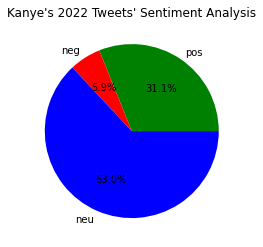

In [56]:
# Plot pie chart 
plt.pie([kanye_tweets_pos, kanye_tweets_neg, kanye_tweets_neu], labels=['pos', 'neg', 'neu'], colors=['g', 'r', 'b'], autopct='%1.1f%%')
plt.title('Kanye\'s 2022 Tweets\' Sentiment Analysis')

# Show plot
plt.show()

As expected from the preliminary analysis, we see that 31.1% of the tweets are positive in nature while just a small 5.9% of the tweets are negative in nature.

In [276]:
# Sort the dictionary by values in ascending order
sorted_tweets = sorted(kanye_tweets_sentiment_score.items(), key=lambda x: x[1], reverse=True)

# Iterate over the dictionary and print tweets with comp <= 0.5
for tweet, comp in sorted_tweets:
    if comp >= 0.5:
        print(f'Comp score: {comp}')
        print(tweet, comp)

Comp score: 0.9723
Praise God. Thank you so much #DoveAwards       God continues to send encouragement      Good is winning     Things are changing     Praise God 0.9723
Comp score: 0.9703
A PRAYER FOR WORLD PEACE
Dear God, thank You for all creation. In the spirit of Jesus of Nazareth and all teachers of peace who inspire the many faith traditions, help me, and all the people of the world, learn how to replace hate, war, oppression, and division with love 0.9703
Comp score: 0.9573
Just to be CLEAR: WE ARE IN ENGAGED WITH HAITI’s GOVERNMENT  to make a transformational INVESTMENT to bring  JOBS,  DEVELOPMENT, HELP SUPPORT LOCAL  FARMERS and FISHERMEN and Build a  new « CITY OF THE FUTURE » in a very beautiful country. 0.9573
Comp score: 0.9571
God loves Balenciaga     Love is the answer       Jesus is the answer     Praying for all of the innocent artist and beautiful humans who make clothing that had nothing to do with the adds     Peoples grandmothers work their for Christ sake 0.9571

In [266]:
# Sort the dictionary by values in ascending order
sorted_tweets = sorted(kanye_tweets_sentiment_score.items(), key=lambda x: x[1])

# Iterate over the dictionary and print tweets with comp <= 0.5
for tweet, comp in sorted_tweets:
    if comp <= -0.5:
        print(f'Comp score: {comp}')
        print(tweet, comp)

Comp score: -0.7845
I stand by Balenciaga and denounce all witch hunts and I cancel cancel culture  Jesus is King     Ending trafficking doesn’t start or end with a fashion campaign for Christ Sake -0.7845
Comp score: -0.765
I'm starting to think anti Semitic means nigger -0.765
Comp score: -0.7263
Opinion: What Ye did today was the Christian version of what many punks did in the 80s. "Fuck your villains!" A rebellion against weaponized ancestral pain. Like it or not, it was meant to slaughter a sacred cow. -0.7263
Comp score: -0.6652
I’m a bit sleepy tonight but when I wake up I’m going death con 3      On JEWISH PEOPLE     The funny thing is I actually can’t be Anti Semitic  because black people are actually Jew also    You guys have toyed with me and tried to black ball anyone whoever opposes your agenda -0.6652
Comp score: -0.6597
JPMorgan Chase and Deutsche Bank have been accused of profiting from and facilitating the sexual abuse of young women and girls by Jeffrey Epstein, accor

In the above result, we see the negatively attributed tweets. These tweets received a lot of backlash from the public and media, and this led to his account ban. 

# Music Lyrics Sentiment Analysis

Now, we extract lyrics to his songs and then perform a similar sentiment analysis on them.

In [148]:
# Using lyricsgenius to obtain song lyrics
import lyricsgenius
import json

In [178]:
# Setting up lyrics genius using genius API token
with open("client_access_token.txt", "r") as f:
    client_access_token = f.read()
genius = lyricsgenius.Genius(client_access_token)

# We exclude all non-songs and songs with these terms -> They indicate unofficial songs
genius.excluded_terms = ["(Remix)", "(Live)", "(Tour)", "(Award)", "(Speech)", "(Demo)", "(Solo)", 
                         "(Version)", "(Interlude)", "(Interview)", "(Freestyle)", "(Show)", "(Instrumental)", 
                         "(OG)", "(Booklet)", "(Original)", "(Reference)", "(Film)", "(Tarantino)", "(SNL)", "(Beat)",
                        "(Season)", "(GQ)", "(Philosophy)", "(Holland)", "(Poetry)"]
genius.remove_section_headers = True
genius.skip_non_songs = True
genius.retries = 20

In [179]:
# kanye_west_artist = genius.search_artist(artist_name="Kanye West", sort="title")

Searching for songs by Kanye West...

Song 1: "."
"03' Bonnie & Clyde (Live)" is not valid. Skipping.
Song 2: "03 Electic Relaxation"
Song 3: "12,000 Acres"
Song 4: "18 Years"
"1996 Fat Beats Freestyle" is not valid. Skipping.
"2004 Tim Westwood Freestyle" is not valid. Skipping.
"2010 BET Hip Hop Awards - Cypher 5" is not valid. Skipping.
"2013 Jimmy Kimmel Interview (Part 1)" is not valid. Skipping.
"2013 Jimmy Kimmel Interview (Part 2)" is not valid. Skipping.
"2013 Yeezus Tour Dates" is not valid. Skipping.
"2013 Zane Lowe BBC Radio Interview Part 1" is not valid. Skipping.
"2013 Zane Lowe BBC Radio Interview Part 2" is not valid. Skipping.
"2014 Yeezus Tour Dates" is not valid. Skipping.
"2015 BET Honors Visionary Award Acceptance Speech" is not valid. Skipping.
"2015 The Breakfast Club Interview" is not valid. Skipping.
"2015 Zane Lowe BBC Radio Interview" is not valid. Skipping.
"2016 MTV VMAs Speech" is not valid. Skipping.
Song 5: "24"
"24 (Buju Banton & SAINt JHN Demo)" is no

Song 67: "Christmas in Harlem"
"Christmas in Harlem (G.O.O.D. Fridays Version)" is not valid. Skipping.
"Chrome Slugs and Harmony (OG)" is not valid. Skipping.
"City of Gods (Demo 3)" is not valid. Skipping.
Song 68: "City of Lost Angels (December 2020)"
"City of Lost Angels (Digital Nas Version)" is not valid. Skipping.
Song 69: "City of Lost Angels (February 2021)"
Song 70: "Classic (Better Than I’ve Ever Been)"
"Classic (Better Than I’ve Ever Been) (DJ Premier Remix)" is not valid. Skipping.
"Clique Freestyle" is not valid. Skipping.
"Clique.tv Interview" is not valid. Skipping.
Song 71: "Closed For Business"
Song 72: "Closed on Sunday"
"Closed on Sunday (Demo)" is not valid. Skipping.
"Closed On Sunday (Piano Solo)" is not valid. Skipping.
Song 73: "Coldest Winter"
"Cold World" is not valid. Skipping.
"College Dorm Sweetheart (30 Hours Demo)" is not valid. Skipping.
"Come and Go (Reference)" is not valid. Skipping.
"Come Back To Me (Demo)" is not valid. Skipping.
Song 74: "Come to 

"Freestyle from Before Infamous Accident" is not valid. Skipping.
"Freestyle with Forbes 01" is not valid. Skipping.
"Freestyle with Forbes 02" is not valid. Skipping.
"Freestyle with Forbes 03" is not valid. Skipping.
Song 142: "Friday Morning, May 25th, 2007"
"Friends" is not valid. Skipping.
"Fuck Flowers (Dem Jointz Demo)" is not valid. Skipping.
"Fuck Flowers (Demo 1)" is not valid. Skipping.
"Fuck Flowers (PopLord Reference Track)" is not valid. Skipping.
Song 143: "Fuck Flowers [V4]"
"Fuck The Internet (Demo)" is not valid. Skipping.
"Fuck The Internet (Demo)" is not valid. Skipping.
"Fuck The Money (remix)" is not valid. Skipping.
"Fuck Up Some Commas Freestyle" is not valid. Skipping.
Song 144: "Fun Mistakes"
"Future Bounce (Demo)" is not valid. Skipping.
Song 145: "Future Sounds"
"Gangster Lovers" is not valid. Skipping.
"GD Anthem (Remix)" is not valid. Skipping.
"Get Away ft. dogen" is not valid. Skipping.
"Get By (Remix)" is not valid. Skipping.
Song 146: "Get ’Em High"
"G

"INDUSTRY BABY / Beat It / POWER / All Of The Lights Mashup" is not valid. Skipping.
"INDUSTRY BABY (Clean Radio Version)" is not valid. Skipping.
"Industry Baby (Remix)" is not valid. Skipping.
Song 220: "I Need to Know"
"I Need to Know (Demo)" is not valid. Skipping.
"In For The Kill (Kanye West Remix)" is not valid. Skipping.
Song 221: "In God’s Country"
"In God’s Country (Demo)" is not valid. Skipping.
"In God’s Country (Reference)" is not valid. Skipping.
Song 222: "Insane"
"Interview Magazine: Cover Story Excerpt" is not valid. Skipping.
"Interviews (Interlude)" is not valid. Skipping.
Song 223: "In The Morning"
Song 224: "Intro"
Couldn't find the lyrics section. Please report this if the song has lyrics.
Song URL: https://genius.com/Kanye-west-intro-2003-lyrics
Song 225: "Intro (2003)"
Song 226: "Intro / Every Hour / Selah"
Song 227: "Intro (Freshmen Adjustment)"
Song 228: "Intro (Get Well Soon)"
Song 229: "Intro (I’m Good)"
"Intro (Original Version)" is not valid. Skipping.
"In

Song 295: "Man Up"
"Marvin & Chardonnay (Xaphoon Jones Remix)" is not valid. Skipping.
"Me Against The Music [Kanye West Remix]" is not valid. Skipping.
Song 296: "Mercy"
"Mercy (Live from Spotify SXSW 2014)" is not valid. Skipping.
"Message In A Bottle Freestyle" is not valid. Skipping.
"Message in a Bottle (Remix)" is not valid. Skipping.
Song 297: "Me Too"
"Midnight" is not valid. Skipping.
"Millions (Live from Spotify SXSW 2014)" is not valid. Skipping.
Song 298: "Mitus Touch"
"MJ AND MESSINA’S INTRO (Say You Will Remix)" is not valid. Skipping.
Song 299: "Mobile Computers | Labels and Stickers – Tagsupplier.com"
Song 300: "Monster"
Song 301: "Moon"
"Moon (Demo)" is not valid. Skipping.
"Moonlight" is not valid. Skipping.
Song 302: "Mr. Miyagi"
"Mr. Miyagi (Demo)" is not valid. Skipping.
"Mr. Miyagi (JAYLIEN Reference)" is not valid. Skipping.
Song 303: "Mrs. Misery"
"Mrs. Misery (Kirby Lauryen Reference)" is not valid. Skipping.
Song 304: "Mrs. Misery [V4.3.14]"
"Mrs. Officer (Vid

Song 402: "Praise God (Explicit)"
"Praise God (Reference)" is not valid. Skipping.
"Prayer" is not valid. Skipping.
"Pray It and Leave It" is not valid. Skipping.
Song 403: "Precious / With Child / Stay On Em"
"Presidential Campaign Rally Speech South Carolina July 2020" is not valid. Skipping.
Song 404: "Pressure"
"Pretty Girl Rock (Remix)" is not valid. Skipping.
Song 405: "Problem"
Song 406: "Promised Land Pt.1"
Song 407: "Pt. 2"
"Puer" is not valid. Skipping.
"Pull Up (Freestyle)" is not valid. Skipping.
Song 408: "Pulp Fiction"
Song 409: "Pure"
Song 410: "Pure Souls"
"Pure Souls (Demo)" is not valid. Skipping.
Song 411: "Pure Souls (Explicit)"
"Pusha Man (Remix)" is not valid. Skipping.
"Put On (Mega Remix)" is not valid. Skipping.
"Put That Shit On (Remix)" is not valid. Skipping.
"Queen Bitch (WWMD Demo)" is not valid. Skipping.
"Question Mark" is not valid. Skipping.
Song 412: "Quiet"
"Raf Simons for Interview Magazine" is not valid. Skipping.
"Raindrops (Kanye West & TGOD808 R

"Sway in the Morning interview with Kanye West (Excerpts)" is not valid. Skipping.
Song 478: "Sweat on My Face"
Song 479: "Sweet Jesus*"
"Sweet Serenade (Live from Spotify SXSW 2014)" is not valid. Skipping.
Song 480: "Swole"
"Take Me Now (Freestyle)" is not valid. Skipping.
"Take Me to the Light (Demo)" is not valid. Skipping.
"Take Me to the Light (Demo)" is not valid. Skipping.
Song 481: "Take One for the Team"
"Takeover Freestyle" is not valid. Skipping.
"Talk to Me (I’m In It Demo)" is not valid. Skipping.
"Teddy" is not valid. Skipping.
"TEKKEN" is not valid. Skipping.
"Tekken (KANGA Demo)" is not valid. Skipping.
"Tell Me When to Go (Remix)" is not valid. Skipping.
Song 482: "Tell The Vision"
"Tell The Vision (Deluxe Version)" is not valid. Skipping.
"Tell The Vision (Demo)" is not valid. Skipping.
"Tell Your Friends (MET Gala Remix)" is not valid. Skipping.
"Tell Your Friends (Remix)" is not valid. Skipping.
Song 483: "Tempat Hantu"
"Testify (Live at the North Sea Jazz Festival

Song 548: "Where U Should Be"
Song 549: "Where You At? (The Whole City Behind Us)"
Song 550: "White Dress"
"White Dress (Alternate Version)" is not valid. Skipping.
Couldn't find the lyrics section. Please report this if the song has lyrics.
Song URL: https://genius.com/Justice-der-white-ferrari-lyrics
"White Ferrari (Magazine Version)" is not valid. Skipping.
Song 551: "Who Will Survive In America"
"Wild’n  Cuz I’m Young (Remix)" is not valid. Skipping.
"Wild n’ Out (Freestyle)" is not valid. Skipping.
Song 552: "Wolves"
"Wolves (Original Version)" is not valid. Skipping.
"Wolves (SNL / Yeezy Season 1)" is not valid. Skipping.
Song 553: "Workout Plan"
"Workout Plan (Live at Abbey Road Studios)" is not valid. Skipping.
Song 554: "Worst Mistake"
"Wouldn’t Be Here If It Wasn’t Cuz Of Dame (Freestyle)" is not valid. Skipping.
Song 555: "Wouldn’t Leave"
"Wouldn’t Leave (Love Everyone Demo)" is not valid. Skipping.
Song 556: "Wouldn’t You Like 2 Ryde"
Song 557: "Wow"
Song 558: "Wow (Alterna

In [180]:
# the above fetch takes ~1-2 hours, so save artist data
# with open('kanye_west_artist.pickle', 'wb') as file:
#     pickle.dump(kanye_west_artist, file)

In [181]:
with open('kanye_west_artist.pickle', 'rb') as file:
    kanye_west_artist = pickle.load(file)

In [248]:
import unicodedata
# preprocessing for future analysis

modified_lyrics = []

for i in range(len(kanye_west_artist.songs)):
    song = kanye_west_artist.songs[i]
    song_title = song.title
    lyrics = song.lyrics
    
    lyrics_sentences = lyrics.split("\n")
    if ("Lyrics" in lyrics_sentences[0]): # Remove "Lyrics" in the beginning
        lyrics_sentences[0] = lyrics_sentences[0].split("Lyrics")[1]
    if lyrics_sentences[-1][-5:] == "Embed":
        lyrics_sentences[-1] = lyrics_sentences[-1][:-5] # Remove Embed
    if lyrics_sentences[-1][-19:] == "You might also like":
        lyrics_sentences[-1] = lyrics_sentences[-1][:-19] # Remove "You might also like"
    
    # replace unicode with actual characters
    for j in range(len(lyrics_sentences)):
        lyrics_sentences[j] = unicodedata.normalize('NFKD', lyrics_sentences[j]).encode('ASCII', 'ignore').decode() 
                
    song_details = [song_title, lyrics_sentences]
    
    modified_lyrics.append(song_details)

In [252]:
# word analysis for all songs combined
all_words_songs = {}
for song_details in modified_lyrics:
    song_lyrics = song_details[1]
    for sentence in song_lyrics:
        sentence_song = sentence.split(' ')
        for song_word in sentence_song:    
            # lowercasing
            song_word = song_word.lower()
            # lemmatize
            song_word = nltk.WordNetLemmatizer().lemmatize(song_word)

            # remove stopwords and empty strings
            if song_word in stopwords or song_word == "":
                continue

            if song_word not in all_words_songs:
                all_words_songs[song_word] = 0
            all_words_songs[song_word] += 1

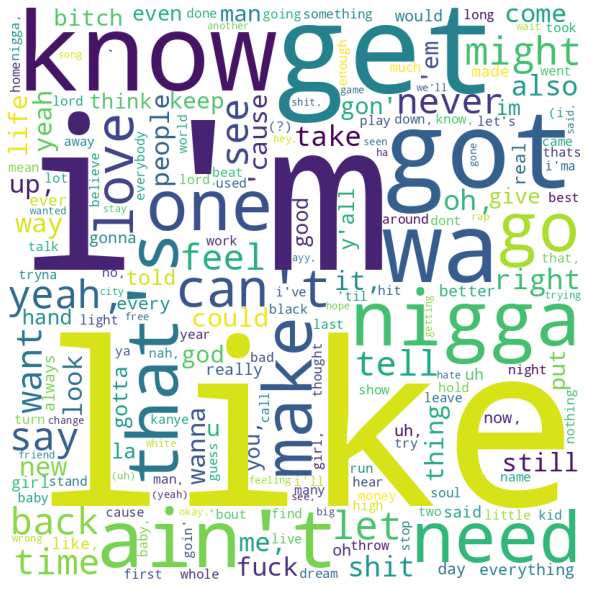

In [253]:
# visualization - wordcloud for song words

# create a WordCloud object with the given parameters
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      min_font_size=10).generate_from_frequencies(all_words_songs)

# plot the WordCloud image using matplotlib
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

# display the image
plt.show()

In [255]:
# filter the dictionary for items with frequency >= 200
all_words_songs_filtered = {k: v for k, v in all_words_songs.items() if v >= 200}

# sort the dictionary by value (frequency) in descending order
all_words_songs_sorted_freq = dict(sorted(all_words_songs_filtered.items(), key=lambda item: item[1], reverse=True))

# print the sorted dictionary
print(all_words_songs_sorted_freq)

{'like': 2157, "i'm": 1798, 'get': 1356, 'know': 1314, 'got': 1285, 'wa': 1068, "ain't": 824, 'nigga': 812, 'one': 670, 'need': 668, "that's": 662, 'go': 635, 'make': 614, "can't": 594, 'love': 593, 'yeah,': 583, 'let': 573, 'might': 566, 'say': 559, 'see': 548, 'back': 515, 'never': 509, 'feel': 502, 'time': 499, 'want': 496, 'tell': 483, 'right': 474, 'take': 457, 'also': 452, 'oh,': 449, 'shit': 445, 'me,': 403, 'way': 399, 'it,': 395, 'new': 394, 'still': 381, 'up,': 372, 'people': 372, 'come': 368, 'look': 360, 'could': 357, 'fuck': 357, "'cause": 353, 'wanna': 352, 'thing': 348, 'life': 345, 'yeah': 344, "gon'": 329, 'god': 329, "'em": 329, 'keep': 327, 'man': 326, 'u': 326, 'bitch': 324, 'put': 319, 'give': 315, 'gotta': 292, "y'all": 285, 'think': 280, 'even': 279, 'told': 273, 'you,': 273, 'im': 267, 'la': 267, 'hand': 265, 'good': 265, 'every': 264, 'real': 258, 'really': 254, 'uh': 247, 'girl': 243, 'ever': 243, 'oh': 241, 'everything': 236, 'made': 235, 'better': 226, 'alwa

From this, we cannot conclude anything, because the presence of curse words is a common occurrence in the rap genre. Therefore, it's difficult to say anything about the lyrics and their sentiment analysis.

In [256]:
# pie chart for sentences
kanye_sentences_pos = 0
kanye_sentences_neg = 0
kanye_sentences_neu = 0

kanye_sentences_sentiment_score = {}

sid = SentimentIntensityAnalyzer()

for song_details in modified_lyrics:
    song_lyrics = song_details[1]
    song_title = song_details[0]
    for sentence in song_lyrics:        
        comp = sid.polarity_scores(sentence)
        comp = comp['compound']
        if comp >= 0.5:
            kanye_sentences_pos += 1
        elif comp > -0.5 and comp < 0.5:
            kanye_sentences_neu += 1
        else:
            kanye_sentences_neg += 1
        kanye_sentences_sentiment_score[sentence] = (comp, song_title)

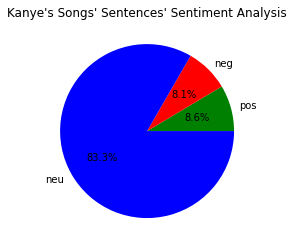

In [258]:
# Plot pie chart 
plt.pie([kanye_sentences_pos, kanye_sentences_neg, kanye_sentences_neu], labels=['pos', 'neg', 'neu'], colors=['g', 'r', 'b'], autopct='%1.1f%%')
plt.title('Kanye\'s Songs\' Sentences\' Sentiment Analysis')

# Show plot
plt.show()

No song level inference can be obtained. We can still say that Kanye's positive sentences have a higher share than the negative ones. 

In [307]:
# Sort the dictionary by values in ascending order
sorted_sentences = sorted(kanye_sentences_sentiment_score.items(), key=lambda x: x[1][0])

# Iterate over the dictionary and print tweets with comp <= 0.5
for sentence, val in sorted_sentences[:20]:
    if val[0] <= -0.5:
        print(f'Comp score: {val[0]} from the song: {val[1]}')
        print(sentence)

Comp score: -0.9954 from the song: On Genius and Fashion
But he wouldnt say that to Anna Wintour. He wouldnt say that to . And now his whole shit based off of rock and roll, and you trying to tell the number one rock star on the planet where the fuck he can go? So he can sell yall, some motherfucking $10,000 pair of jeans? Fuck fashion. Fuck fashion. I mean, whats the worst thing they gonna do, not help me again? Whats the worst they gonna do tell me I cant go to these shows again? Whats the worst they gonna do, tell me that because Im a musician, I dont have any ideas for clothing again? Whats the worst they gonna do, marginalize me again? And never let Pharrell get his shot, and never let Lenny get his shot?
Comp score: -0.9852 from the song: On Dreaming and Success
Cause most people, you know they say, they say people in my position, what ever that position is, like a celebrity or you make money, you have some type of status or some shit, you don't wanna fuck it up right? You don't 

From here, we can see that the top 10 negative songs have significant curse words and negative meanings. 

In [272]:
# Sort the dictionary by values in ascending order
sorted_sentences = sorted(kanye_sentences_sentiment_score.items(), key=lambda x: x[1][0], reverse=True)

# Iterate over the dictionary and print tweets with comp >= 0.5
for sentence, val in sorted_sentences[:10]:
    if val[0] >= 0.5:
        print(f'Comp score: {val[0]} from the song: {val[1]}')
        print(sentence)

Comp score: 0.9953 from the song: On Genius and Fashion
And the designers would love it when Lenny Kravitz would show up at their fashion show. Yeah we gonna take some pictures of Lenny Kravitz and we gonna say hes at the such and such show, and thats gonna promote our brand. Hey Lenny, promote it the best you can. Hey Lenny, promote it the best you can. Hey Lenny, promote it the best you can. Best you can. Hey Kanye, promote it the best you can. Hey Kanye, promote us the best you can. From Paris to New York all the way to Japan. Hey Kanye, I mean Lenny, I mean any of you niggas, promote it the best you can. Any of you niggas promote if the best you can
Comp score: 0.9907 from the song: Kanye West & Taylor Swift’s ‘Famous’ Lyric Phone Conversation
Kanye: Okay. Yeah, well, this is the thing why Im calling you because you got an army. You own a country of motherfucking two billion people, basically, that if you felt that its funny and cool and like hip hop and felt like, you know, just T

From this, we see that the most positive songs have a very strong positive meaning. 

From just sentence analysis, concluding anything might be a bit difficult. Still, we can say as per the pie chart that the songs are slightly inclined towards being more positive.

In [303]:
# pie chart for songs

kanye_songs_pos = 0
kanye_songs_neg = 0
kanye_songs_neu = 0

kanye_songs_sentiment_score = {}

sid = SentimentIntensityAnalyzer()

for song_details in modified_lyrics:
    song_lyrics = song_details[1]
    song_title = song_details[0]
    average_comp_score = 0.0
    for sentence in song_lyrics:        
        comp = sid.polarity_scores(sentence)
        comp = comp['compound']
        average_comp_score += comp
    average_comp_score /= float(len(song_lyrics))    
    if average_comp_score >= 0.5:
        kanye_songs_pos += 1
    elif average_comp_score < 0.5 and average_comp_score > -0.5:
        kanye_songs_neu += 1
    else:
        kanye_songs_neg += 1
    kanye_songs_sentiment_score[song_title] = average_comp_score

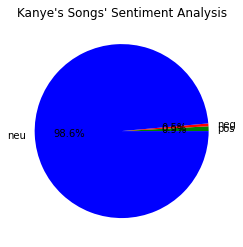

In [304]:
# Plot pie chart 
plt.pie([kanye_songs_pos, kanye_songs_neg, kanye_songs_neu], labels=['pos', 'neg', 'neu'], colors=['g', 'r', 'b'], autopct='%1.1f%%')
plt.title('Kanye\'s Songs\' Sentiment Analysis')

# Show plot
plt.show()

As we can see from the above graph, we see that the number of positive and negative songs are more or less same, with positive having just one more.

In [305]:
# Sort the dictionary by values in ascending order
sorted_songs = sorted(kanye_songs_sentiment_score.items(), key=lambda x: x[1])

# Iterate over the dictionary and print songs with comp <= 0.5
for song, val in sorted_songs:
    if val <= -0.5:
        print(f'Comp score: {val}')
        print(song)

Comp score: -0.71718
On Being a Celebrity
Comp score: -0.693975
On Hurricane Katrina
Comp score: -0.5789666666666666
On Obama: “I’m Past That”


In [306]:
# Sort the dictionary by values in descending order
sorted_songs = sorted(kanye_songs_sentiment_score.items(), key=lambda x: x[1], reverse=True)

# Iterate over the dictionary and print songs with comp >= 0.5
for song, val in sorted_songs:
    if val >= 0.5:
        print(f'Comp score: {val}')
        print(song)

Comp score: 0.9672
On Truthfulness
Comp score: 0.9513
On Fern Mallis
Comp score: 0.8294
Tempat Hantu
Comp score: 0.6385238095238097
Kanye West’s Grammy Honors
Comp score: 0.58845
On Creative Frustration


From the above results, we can see that the positive and negative songs are more or less same in number.

From the sentence analysis above, we can see that the type and meaning of words and sentences used that contribute to the highest negative scores may actually show a thought process which is reflected in the most negative tweets. While this study doesn't correlate negativity in song lyrics and tweets, it gives an insight into a possibility of song lyrics representing a person's state of mind. 